# nnU-Net Data Preparation

## Introduction
This notebook combines all the necessary steps for preparing data for nnU-Net, including fetching and splitting the original data, downsampling images and labels, remapping label values, and creating the `dataset.json` file.

## Imports and Setup

In [74]:
import os
import random
import json
import shutil
import SimpleITK as sitk
import numpy as np

# Define variables for dataset types
ascending = "Ascending"
sinuses = "Sinuses"


## Downsampling
### Resample Images and Labels

In [75]:
# Define target spacing
target_spacing = (2.0, 2.0, 2.0)

def resample_image(image_path, output_path, is_label=False):
    image = sitk.ReadImage(image_path)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / target_spacing[i])))
        for i in range(3)
    ]
    
    interpolator = sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear

    resampled_image = sitk.Resample(
        image,
        new_size,
        sitk.Transform(),
        interpolator,
        image.GetOrigin(),
        target_spacing,
        image.GetDirection(),
        0,
        image.GetPixelID()
    )
    
    sitk.WriteImage(resampled_image, output_path)

    # Verify consistency
    # resampled_image = sitk.ReadImage(output_path)
    # assert resampled_image.GetSpacing() == target_spacing, "Spacing mismatch"
    # assert resampled_image.GetDirection() == image.GetDirection(), f"Direction mismatch: {resampled_image.GetDirection()} != {image.GetDirection()}"

    # print(f"Resampled {output_path} successfully with consistent coordinates.")

def downsample_images():
    images_dir = "LSS/ECE5995_AorticWall/Data/images"
    output_images_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/Common_2mm_images"

    os.makedirs(output_images_dir, exist_ok=True)
    processed_count = 0
    
    for image_file in sorted(os.listdir(images_dir)):
        if image_file.endswith(".nii.gz"):
            image_path = os.path.join(images_dir, image_file)
            output_image_path = os.path.join(output_images_dir, image_file)
            try:
                resample_image(image_path, output_image_path, is_label=False)
                processed_count += 1
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
            
    print(f"Resampling Finished! {processed_count} images are saved in {output_images_dir}")

def downsample_labels(dataset_type):
    labels_dir = "LSS/ECE5995_AorticWall/Data/labels"
    output_labels_dir = f"LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/{dataset_type}_2mm_labels"
    
    os.makedirs(output_labels_dir, exist_ok=True)
    processed_count = 0
    
    for label_file in sorted(os.listdir(labels_dir)):
        if label_file.endswith(f"_{dataset_type}.nii.gz"):
            label_path = os.path.join(labels_dir, label_file)
            output_label_path = os.path.join(output_labels_dir, label_file)
            try:
                resample_image(label_path, output_label_path, is_label=True)
                processed_count += 1
            except Exception as e:
                print(f"Error processing {label_file}: {e}")

    print(f"Resampling Finished! {processed_count} labels are saved in {output_labels_dir}")

# Downsample images once
downsample_images()

# Downsample labels for Ascending dataset
downsample_labels(ascending)

# Downsample labels for Sinuses dataset
downsample_labels(sinuses)


Resampling Finished! 215 images are saved in Resampled/Common_2mm_images
Resampling Finished! 215 labels are saved in Resampled/Ascending_2mm_labels
Resampling Finished! 215 labels are saved in Resampled/Sinuses_2mm_labels


## Data Preparation
### Fetch and Split Downsampled Data

In [76]:
def setup_directories(dataset_type):
    
    images_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/Common_2mm_images"
    labels_dir = f"LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/{dataset_type}_2mm_labels"

    print(f"dataset_type: {dataset_type}")  # Debugging print statement

    if dataset_type == ascending:
        dataset_number = "001"
    elif dataset_type == sinuses:
        dataset_number = "002"
    else:
        dataset_number = "000"  # Default or other types
    
    output_dir = f"LSS/ECE5995_AorticWall/Workplace_VincentCai/nnUNet_raw/Dataset{dataset_number}_{dataset_type}"
    print(f"output_dir: {output_dir}")  # Debugging print statement

    images_train_dir = os.path.join(output_dir, "imagesTr")
    images_test_dir = os.path.join(output_dir, "imagesTs")
    labels_train_dir = os.path.join(output_dir, "labelsTr")
    labels_test_dir = os.path.join(output_dir, "labelsTs")
    train_test_record_file = os.path.join(output_dir, "train_test_split.json")

    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_test_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_test_dir, exist_ok=True)

    return images_dir, labels_dir, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, train_test_record_file


In [77]:
def prepare_data(dataset_type):
    images_dir, labels_dir, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, train_test_record_file = setup_directories(dataset_type)
    
    all_images = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])

    random.seed(91)
    random.shuffle(all_images)

    dataset_usage_ratio = 0.2  
    train_test_ratio = 0.8     

    subset_count = int(len(all_images) * dataset_usage_ratio)
    subset_images = all_images[:subset_count]

    train_count = int(len(subset_images) * train_test_ratio)

    train_files = subset_images[:train_count]
    test_files = subset_images[train_count:]

    train_test_record = {
        "dataset_usage_ratio": dataset_usage_ratio,
        "train_test_ratio": train_test_ratio,
        "train_count": len(train_files),
        "test_count": len(test_files),
        "train": [],
        "test": [],
        "filename_mapping": {}  
    }

    for idx, image_filename in enumerate(train_files):
        image_path = os.path.join(images_dir, image_filename)

        new_filename = f"{dataset_type}_{idx:05d}_0000.nii.gz"
        train_test_record["train"].append(new_filename)
        train_test_record["filename_mapping"][new_filename] = image_filename  

        shutil.copy(image_path, os.path.join(images_train_dir, new_filename))

        label_filename = image_filename.replace(".nii.gz", f"_{dataset_type}.nii.gz")
        label_path = os.path.join(labels_dir, label_filename)

        if os.path.exists(label_path):
            new_label_filename = f"{dataset_type}_{idx:05d}.nii.gz"
            shutil.copy(label_path, os.path.join(labels_train_dir, new_label_filename))
            train_test_record["filename_mapping"][new_label_filename] = label_filename 

    for idx, image_filename in enumerate(test_files):
        image_path = os.path.join(images_dir, image_filename)

        new_filename = f"{dataset_type}_{idx+train_count:05d}_0000.nii.gz"
        train_test_record["test"].append(new_filename)
        train_test_record["filename_mapping"][new_filename] = image_filename

        shutil.copy(image_path, os.path.join(images_test_dir, new_filename))

        label_filename = image_filename.replace(".nii.gz", f"_{dataset_type}.nii.gz")
        label_path = os.path.join(labels_dir, label_filename)

        if os.path.exists(label_path):
            new_label_filename = f"{dataset_type}_{idx+train_count:05d}.nii.gz"
            shutil.copy(label_path, os.path.join(labels_test_dir, new_label_filename))
            train_test_record["filename_mapping"][new_label_filename] = label_filename  

    with open(train_test_record_file, "w") as f:
        json.dump(train_test_record, f, indent=4)

    print(f"Data split! Using {dataset_usage_ratio * 100}% of the original dataset")
    print(f"Training set: {len(train_files)} images and {len(os.listdir(labels_train_dir))} labels")
    print(f"Testing set: {len(test_files)} images and {len(os.listdir(labels_test_dir))} labels")
    print(f"Data report is saved at {train_test_record_file}")

# Prepare data for Ascending dataset
prepare_data(ascending)

# Prepare data for Sinuses dataset
prepare_data(sinuses)

dataset_type: Ascending
output_dir: nnUNet_raw/Dataset001_Ascending
Data split! Using 20.0% of the original dataset
Training set: 34 images and 34 labels
Testing set: 9 images and 9 labels
Data report is saved at nnUNet_raw/Dataset001_Ascending/train_test_split.json
dataset_type: Sinuses
output_dir: nnUNet_raw/Dataset002_Sinuses
Data split! Using 20.0% of the original dataset
Training set: 34 images and 34 labels
Testing set: 9 images and 9 labels
Data report is saved at nnUNet_raw/Dataset002_Sinuses/train_test_split.json


## Label Remapping
### Remap Label Values

In [78]:
def remap_labels(label_path, dataset_type):
    # print(f"Processing {label_path}...")
    
    image = sitk.ReadImage(label_path)
    array = sitk.GetArrayFromImage(image)

    if dataset_type == ascending:
        array[array == 4] = 1
    elif dataset_type == sinuses:
        array[(array == 1) | (array == 2) | (array == 3)] = array[(array == 1) | (array == 2) | (array == 3)]

    new_image = sitk.GetImageFromArray(array)
    new_image.SetSpacing(image.GetSpacing())
    new_image.SetOrigin(image.GetOrigin())
    new_image.SetDirection(image.GetDirection())

    sitk.WriteImage(new_image, label_path)
    # print(f"Updated {label_path}")

def process_labels(dataset_type):
    _, _, _, _, labels_train_dir, labels_test_dir, _ = setup_directories(dataset_type)
    
    for filename in os.listdir(labels_train_dir):
        if filename.endswith(".nii.gz"):
            remap_labels(os.path.join(labels_train_dir, filename), dataset_type)
    
    for filename in os.listdir(labels_test_dir):
        if filename.endswith(".nii.gz"):
            remap_labels(os.path.join(labels_test_dir, filename), dataset_type)
    
    print(f"All the labels for {dataset_type} are remapped.")

# Process labels for Ascending dataset
process_labels(ascending)

# Process labels for Sinuses dataset
process_labels(sinuses)


dataset_type: Ascending
output_dir: nnUNet_raw/Dataset001_Ascending
All the labels for Ascending are remapped.
dataset_type: Sinuses
output_dir: nnUNet_raw/Dataset002_Sinuses
All the labels for Sinuses are remapped.


## Check Direction Consistency

In [83]:
# Directories containing images and segmentations
# images_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/nnUNet_raw/Dataset001_Ascending/imagesTr"
# labels_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/nnUNet_raw/Dataset001_Ascending/labelsTr"

images_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/nnUNet_raw/Dataset002_Sinuses/imagesTr"
labels_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/nnUNet_raw/Dataset002_Sinuses/labelsTr"
    
# Get list of image and segmentation files
image_files = [f for f in os.listdir(images_dir) if f.endswith('_0000.nii.gz')]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.nii.gz')]

all_consistent = True

# Check origins for all corresponding image and segmentation files
for image_file in image_files:
    # Derive the corresponding segmentation file name
    base_name = image_file.replace('_0000.nii.gz', '')
    label_file = f"{base_name}.nii.gz"
    
    # Check if the segmentation file exists
    if label_file in label_files:
        # Read the image and segmentation
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, label_file)
        
        image = sitk.ReadImage(image_path)
        label = sitk.ReadImage(label_path)
        
        # Get the origins
        image_origin = image.GetOrigin()
        label_origin = label.GetOrigin()
        
        # Check if the origins are the same
        if image_origin != label_origin:
            print(f"Origins are inconsistent for {base_name}.\nImage origin: {image_origin}\nSegmentation origin: {label_origin}")
            all_consistent = False
    else:
        print(f"Segmentation file not found for {base_name}.")
        all_consistent = False

if all_consistent:
    print("All origins are consistent.")


All origins are consistent.


## Dataset JSON Creation
### Create dataset.json

In [84]:
def create_dataset_json(dataset_type):
    _, _, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, _ = setup_directories(dataset_type)

    train_cases = sorted([f.replace(".nii.gz", "") for f in os.listdir(images_train_dir) if f.endswith(".nii.gz")])
    test_cases = sorted([f.replace(".nii.gz", "") for f in os.listdir(images_test_dir) if f.endswith(".nii.gz")])

    if dataset_type == ascending:
        labels_dict = {
            "background": 0,
            "ascending_aorta": 1
        }
    elif dataset_type == sinuses:
        labels_dict = {
            "background": 0,
            "root_1": 1,
            "root_2": 2,
            "root_3": 3
        }

    dataset_info = {
        "channel_names": {"0": "CT"},  
        "labels": labels_dict,
        "numTraining": len(train_cases),
        "file_ending": ".nii.gz",      
        "training": [{"image": f"./imagesTr/{case}.nii.gz", "label": f"./labelsTr/{case}.nii.gz"} for case in train_cases],
        "test": [{"image": f"./imagesTs/{case}.nii.gz", "label": f"./labelsTs/{case}.nii.gz"} for case in test_cases]
    }

    dataset_dir = os.path.dirname(images_train_dir)
    json_path = os.path.join(dataset_dir, "dataset.json")
    with open(json_path, "w") as json_file:
        json.dump(dataset_info, json_file, indent=4)
    
    print(f"Dataset JSON created at {json_path}")

# Create dataset JSON for Ascending dataset
create_dataset_json(ascending)

# Create dataset JSON for Sinuses dataset
create_dataset_json(sinuses)


dataset_type: Ascending
output_dir: nnUNet_raw/Dataset001_Ascending
Dataset JSON created at nnUNet_raw/Dataset001_Ascending/dataset.json
dataset_type: Sinuses
output_dir: nnUNet_raw/Dataset002_Sinuses
Dataset JSON created at nnUNet_raw/Dataset002_Sinuses/dataset.json


## Function: plot_random_image_and_label

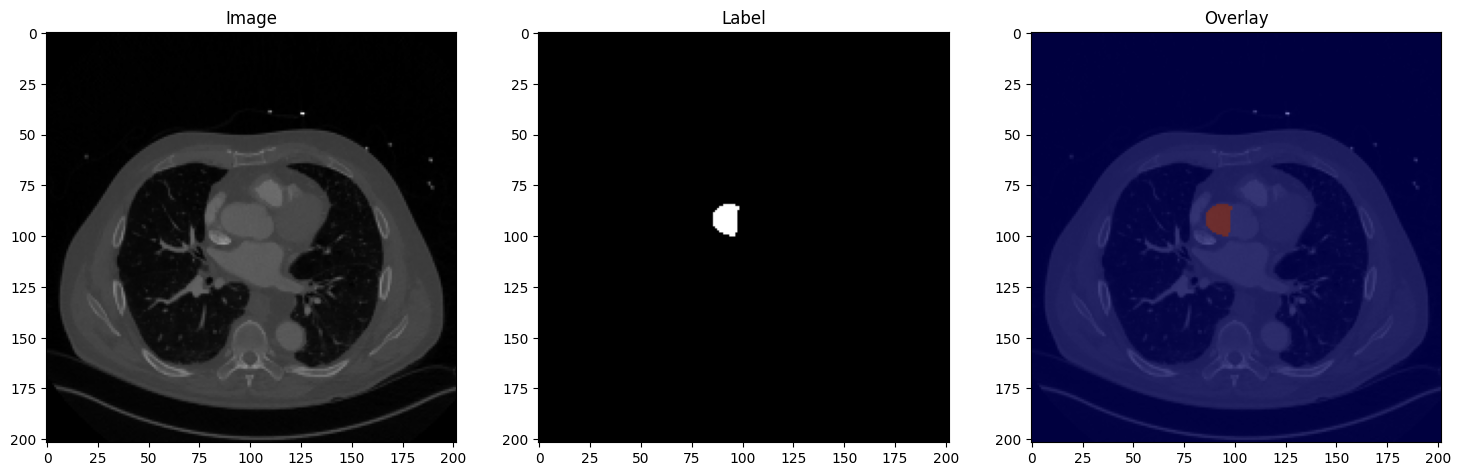

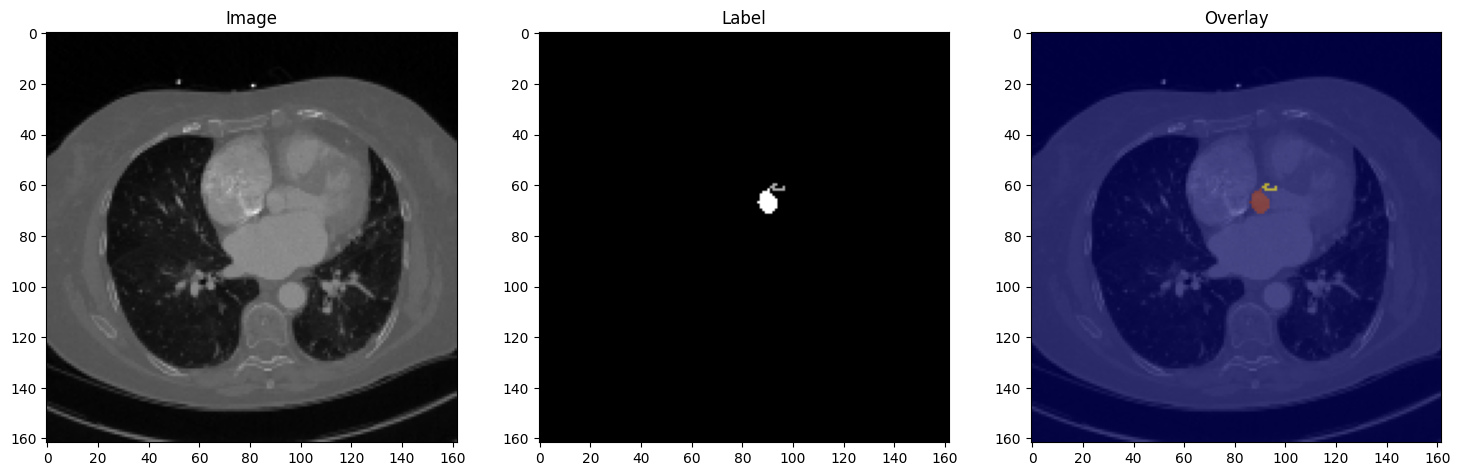

In [87]:
def plot_random_image_and_label(dataset_type):
    # Define the directories for resampled images and labels
    images_dir = "LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/Common_2mm_images"
    labels_dir = f"LSS/ECE5995_AorticWall/Workplace_VincentCai/Resampled/{dataset_type}_2mm_labels"

    # Get a list of all image files in the images directory
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".nii.gz")]

    # Randomly select one image file
    random_image_file = random.choice(image_files)

    # Construct the corresponding label file path
    label_file = random_image_file.replace(".nii.gz", f"_{dataset_type}.nii.gz")

    # Read the image and label using SimpleITK
    image_path = os.path.join(images_dir, random_image_file)
    label_path = os.path.join(labels_dir, label_file)

    image = sitk.ReadImage(image_path)
    label = sitk.ReadImage(label_path)

    # Ensure the origin, spacing, and direction are consistent
    label.SetOrigin(image.GetOrigin())
    label.SetSpacing(image.GetSpacing())
    label.SetDirection(image.GetDirection())
    
    # Convert the images to numpy arrays for plotting
    image_array = sitk.GetArrayFromImage(image)
    label_array = sitk.GetArrayFromImage(label)

    # Plot the image and label side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image_array[image_array.shape[0] // 2], cmap="gray")
    axes[0].set_title("Image")
    
    axes[1].imshow(label_array[label_array.shape[0] // 2], cmap="gray")
    axes[1].set_title("Label")
    
    # Plot overlay
    axes[2].imshow(image_array[image_array.shape[0] // 2], cmap="gray")
    axes[2].imshow(label_array[label_array.shape[0] // 2], cmap="jet", alpha=0.5)
    axes[2].set_title("Overlay")
    
    plt.show()

# Call the function to plot a random image and its corresponding label for Ascending dataset
plot_random_image_and_label(ascending)

# Call the function to plot a random image and its corresponding label for Sinuses dataset
plot_random_image_and_label(sinuses)

## Summary and Next Steps

In this notebook, we have prepared the data for nnU-Net by resampling images and labels, setting up directories, and remapping labels.

Next, we can run the following commands:

1. **Plan and Preprocess the Dataset**:
   ```sh   
   nnUNetv2_plan_and_preprocess -d 001 -pl nnUNetPlannerResEncL -gpu_memory_target 48 -overwrite_plans_name nnUNetResEncUNetPlans_48G --verify_dataset_integrity

   ```
   
2. **Train the Model**:

    - 2D:
        ```sh
        nnUNetv2_train 001 2d 0 -p nnUNetResEncUNetPlans_48G -num_gpus 1 --npz
        ```
   
    - 3D:
        ```sh
        nnUNetv2_train 001 3d_fullres 0 -p nnUNetResEncUNetPlans_48G -num_gpus 1 --npz
        ```